# Xarray Tips and Tricks

## Build a multi-file dataset from an OpenDAP server

One thing we love about xarray is the `open_mfdataset` function, which combines many netCDF files into a single xarray Dataset.

But what if the files are stored on a remote server and accessed over OpenDAP. An example can be found in NOAA's NCEP Reanalysis catalog.

https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/ncep.reanalysis/surface/catalog.html

The dataset is split into different files for each variable and year. For example, a single file for surface air temperature looks like:

http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc

We can't just call

    open_mfdataset("http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.*.nc")
    
Because wildcard expansion doesn't work with OpenDAP endpoints. The solution is to manually create a list of files to open.

In [1]:
base_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995'

files = [f'{base_url}.{year}.nc' for year in range(1948, 2019)]
files

['http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1949.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1950.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1951.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1952.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1953.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1954.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1955.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1956.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1957.nc',
 'http://w

In [2]:
import xarray as xr
%matplotlib inline

ds = xr.open_mfdataset(files)
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 103596)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * time     (time) datetime64[ns] 1948-01-01 1948-01-01T06:00:00 ...
Data variables:
    air      (time, lat, lon) float32 dask.array<shape=(103596, 73, 144), chunksize=(1464, 73, 144)>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (1948)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         created 99/05/11 by Hoop (netCDF2.3)\nCo...
    References:                      http://www.esrl.noaa.gov/psd/data/gridde...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    DODS_EXTRA.Unlimited_Dimension:  time

We have now opened the entire ensemble of files on the remote server as a single xarray Dataset!

## Perform Correlation Analysis

Many people want to look at correlations (usually in time) in their final projects.
Unfortunately, this is not currently part of xarray (but it will be added soon! -- see [open issue](https://github.com/pydata/xarray/issues/1115)).

In the meantime, the following functions works pretty well.

In [3]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [4]:
ds = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 1960-03-15 ...
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

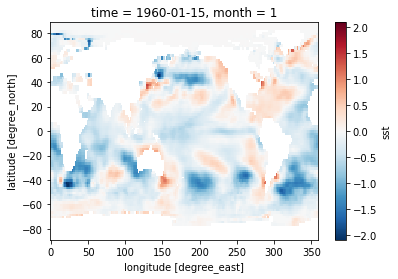

In [5]:
sst = ds.sst
sst_clim = sst.groupby('time.month').mean(dim='time')
sst_anom = sst.groupby('time.month') - sst_clim

%matplotlib inline
sst_anom[0].plot()

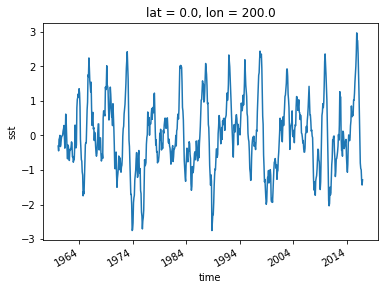

In [6]:
sst_ref = sst_anom.sel(lon=200, lat=0, method='nearest')
sst_ref.plot()

Text(0.5,1,'Correlation btw. global SST Anomaly and SST Anomaly at one point')

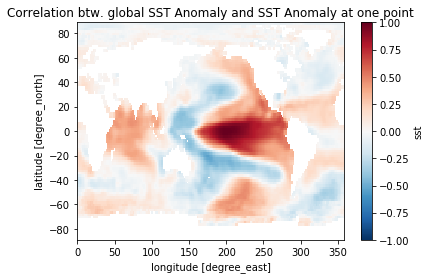

In [7]:
sst_cor = corrrelation(sst_anom, sst_ref, dims='time')
pc = sst_cor.plot()
pc.axes.set_title('Correlation btw. global SST Anomaly and SST Anomaly at one point')

## Fix poorly encoded time coordinates

Many datasets, especially from INGRID, are encoded with "months since" as the time unit. Trying to open these in xarray currently gives an error.

In [8]:
import cftime
cftime.__version__

'1.0.3'

In [9]:
import xarray as xr

url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/dods'
ds = xr.open_dataset(url)

ValueError: unable to decode time units 'months since 1960-01-01' with calendar '360'. Try opening your dataset with decode_times=False.

One way to avoid this is to simply not decode the times:

In [10]:
ds = xr.open_dataset(url, decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (T: 478, X: 144, Y: 72)
Coordinates:
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
  * T        (T) float32 228.5 229.5 230.5 231.5 232.5 233.5 234.5 235.5 ...
  * Y        (Y) float32 -88.75 -86.25 -83.75 -81.25 -78.75 -76.25 -73.75 ...
Data variables:
    prcp     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

However, this is not satisfying, because now we can't use xarray's time aware features (like resample).

A better option has recently become possible. First we need the latest development version of the [cftime](https://github.com/Unidata/cftime) package.

In [11]:
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

ds = fix_calendar(ds)
ds = xr.decode_cf(ds)
ds

<xarray.Dataset>
Dimensions:  (T: 478, X: 144, Y: 72)
Coordinates:
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
  * T        (T) datetime64[ns] 1979-01-16 1979-02-16 1979-03-16 1979-04-16 ...
  * Y        (Y) float32 -88.75 -86.25 -83.75 -81.25 -78.75 -76.25 -73.75 ...
Data variables:
    prcp     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL